# Simion Cristian
# Copyright © 2021

# Incarcare module

In [ ]:
!nvidia-smi

Tue Jun 29 16:03:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/alexlee-gk/lpips-tensorflow.git
!cd lpips-tensorflow && pip install -r requirements.txt

Cloning into 'lpips-tensorflow'...
remote: Enumerating objects: 67, done.
remote: Total 67 (delta 0), reused 0 (delta 0), pack-reused 67
Unpacking objects: 100% (67/67), done.


In [ ]:
# Functii de sistem
import os, sys

# Functii din PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Pentru setul de date
from torch.utils.data import Dataset, DataLoader

# Pentru debugging
import torch.autograd.profiler as profiler

# Biblioteci standard de prelucrare
import numpy as np
import matplotlib.pyplot as plt

# Bara de progres
from tqdm.notebook import tqdm

# Operatii cu imagini
import imageio 
from skimage.transform import rescale

# Tensorflow (pentru metrici)
import tensorflow as tf
%tensorflow_version 1.x
# Cale pentru LPIPS
sys.path.append('/content/lpips-tensorflow')
import lpips_tf

# Operatii cu json
import json

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Incarcarea datelor

In [ ]:
class TinyNerfDataset(Dataset):
    def __init__(self, dir):
        self.dir = dir

        data = np.load(os.path.join(dir, 'tiny_nerf_data.npz'))
        images = torch.from_numpy(data['images'])[:100]
        poses = torch.from_numpy(data['poses'])[:100]
        focal = data['focal']

        H, W = images.shape[1:3]

        # (len(images) * W * H, 3)
        self.rgbs = images.view((-1, 3))
        # (len(poses), W * H, 2, 3)
        self.rays = [extract_rays(H, W, focal, pose) for pose in poses]
        self.rays = torch.cat(self.rays)
        self.rays = self.rays.view((-1, 2, 3))

    def __len__(self):
        return self.rgbs.shape[0]
    
    def __getitem__(self, idx):
        sample = { "ray": self.rays[idx], "rgb": self.rgbs[idx] }
        return sample

In [ ]:
class BlenderRaysDataset(Dataset):
    def __init__(self, dir, downscale_factor=2, role='train', blend_alpha=True):
        """
            dir: folder-ul in care se afla datele:
                    un alt folder cu numele tipului + 
                    un fisier transforms_{role}.json)
            downscale_factor: factorul cu care se micsoreaza rezolutia
            role: un string care indica tipul setului de date, poate fi:
                ['train', 'val', 'test']
        """
        self.dir = dir
        with open(os.path.join(dir, 'transforms_' + role + '.json'), 'r') as f:
            metadata = json.load(f)

        images = []
        poses = []

        for i, frame in enumerate(metadata['frames']):
            path = os.path.join(dir, frame['file_path'] + '.png')
            raw_img = imageio.imread(path)

            if np.isclose(downscale_factor, 1.):
                img = np.clip(raw_img / 255, 0., 1.).astype(np.float32)
            else:
                # Obs: channel_axis=-1 in loc multichannel pentru skimage modern
                img = rescale(raw_img, scale = 1 / downscale_factor, 
                                multichannel=True).astype(np.float32)
            images.append(img)
        
            pose = np.array(frame['transform_matrix'], dtype=np.float32)
            poses.append(pose)

            # Folosim un set mai mic de date pentru validare
            if role != 'train' and i == 30 - 1:
                print("Trimming non-training data")
                break
        
        # torch.tensor(np.array(LM)) mult mai rapid decat torch.tensor(LM)
        # daca LM este o lista de matrice numpy
        # https://github.com/pytorch/pytorch/issues/13918
        images = torch.tensor(np.array(images))
        self.poses = torch.tensor(np.array(poses))

        H, W = images[0].shape[:2]

        fov_x = metadata['camera_angle_x']
        self.focal = W / (2 * np.tan(fov_x / 2))
        print(self.focal)

        if blend_alpha:
            rgb = images[..., :3]
            alpha = images[..., -1:]
            images = alpha * rgb + (1. - alpha)
        else:
            images = images[..., :3]
        
        # (len(images) * W * H, 3)
        self.rgbs = images.view((-1, 3))
        # (len(poses), W * H, 2, 3)
        self.rays = [extract_rays(H, W, self.focal, pose) for pose in self.poses]
        self.rays = torch.cat(self.rays)
        self.rays = self.rays.view((-1, 2, 3))

        print(self.rgbs.shape, self.rays.shape)

    def __len__(self):
        return self.rgbs.shape[0]
    
    def __getitem__(self, idx):
        sample = { "ray": self.rays[idx], "rgb": self.rgbs[idx] }
        return sample

In [ ]:
class BlenderImageDataset(Dataset):
    def __init__(self, dir, downscale_factor=2, role='train', blend_alpha=True):
        """
            dir: folder-ul in care se afla datele:
                    un alt folder cu numele tipului + 
                    un fisier transforms_{role}.json)
            downscale_factor: factorul cu care se micsoreaza rezolutia
            role: un string care indica tipul setului de date, poate fi:
                ['train', 'val', 'test']
        """
        self.dir = dir
        with open(os.path.join(dir, 'transforms_' + role + '.json'), 'r') as f:
            metadata = json.load(f)

        images = []
        poses = []

        for frame in metadata['frames']:
            path = os.path.join(dir, frame['file_path'] + '.png')
            raw_img = imageio.imread(path)

            if np.isclose(downscale_factor, 1.):
                img = np.clip(raw_img / 255, 0., 1.).astype(np.float32)
            else:
                # Obs: channel_axis=-1 in loc multichannel pentru skimage modern
                img = rescale(raw_img, scale = 1 / downscale_factor, 
                            multichannel=True).astype(np.float32)
            images.append(img)
        
            pose = np.array(frame['transform_matrix'], dtype=np.float32)
            poses.append(pose)
        
        # torch.tensor(np.array(LM)) mult mai rapid decat torch.tensor(LM)
        # daca LM este o lista de matrice numpy
        # https://github.com/pytorch/pytorch/issues/13918
        images = torch.tensor(np.array(images))
        self.poses = torch.tensor(np.array(poses))

        H, W = images[0].shape[:2]

        fov_x = metadata['camera_angle_x']
        focal = W / (2 * np.tan(fov_x / 2))
        print(focal)

        if blend_alpha:
            rgb = images[..., :3]
            alpha = images[..., -1:]
            images = alpha * rgb + (1. - alpha)
        else:
            images = images[..., :3]
        
        self.images = images
        # hwf = (Height, Width, Focal)
        self.hwf = (H, W, focal)

        print(self.images.shape, self.poses.shape, self.hwf)

    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        sample = { 
            "image": self.images[idx], 
            "pose": self.poses[idx], 
            "hwf": self.hwf
            }
        return sample

## LLFF

In [ ]:
def normalize(x):
    return x / np.linalg.norm(x, axis=0, keepdims=True)

def poses_average(poses):
    # Extram translatia medie: (1, 4)
    mean_center = np.mean(poses[..., -1], axis=0)
    
    # Extragem axele y, z medii: (1, 4)
    mean_z = np.mean(poses[..., 2], axis=0)
    mean_y = np.mean(poses[..., 1], axis=0)

    # Deducem noile directii: (1, 4)
    new_x = np.cross(mean_y, mean_z)
    new_y = np.cross(mean_z, new_x)

    # Normalizam vectorii
    x = normalize(new_x)
    y = normalize(new_y)
    z = normalize(mean_z)

    avg_pose = np.column_stack((x, y, z, mean_center))

    return avg_pose

In [ ]:
def recenter_poses(poses):
    # Pentru a centra pose-urile, inmultim inversa matricei pose medii cu 
    # fiecare matrice pose in parte
    avg_pose = poses_average(poses)
    ones = np.array([0., 0., 0., 1.])
    avg_pose = np.vstack((avg_pose, ones))

    # Pentru a concatena pe o axa, trebuie sa am aceeasi forma pe celelalte
    ones_expanded = np.broadcast_to(ones, (poses.shape[0], 1, 4))
    poses_square = np.concatenate((poses, ones_expanded), axis=1)

    inv_avg = np.linalg.inv(avg_pose)
    centered_poses = inv_avg @ poses_square

    return centered_poses[..., :3, :]

In [ ]:
def convert_to_ndc(H, W, focal, near, rays):
    o, d = rays[:, 0, :], rays[:, 1, :]

    # t = -(n + o_z) / d_z, (num_rays)
    t = -(near + o[..., 2]) / d[..., 2]
    o = o + t.unsqueeze(-1) * d

    ox, oy, oz = torch.split(o, 1, dim=-1)
    dx, dy, dz = torch.split(d, 1, dim=-1)

    x_coef = -focal / (W / 2)
    y_coef = -focal / (H / 2)
    
    new_ox = x_coef * ox / oz
    new_oy = y_coef * oy / oz
    new_oz = 1. + 2 * near / oz

    new_dx = x_coef * (dx / dz - ox / oz)
    new_dy = y_coef * (dy / dz - oy / oz)
    new_dz = -2. * near / oz

    # (num_rays, 3)
    new_o = torch.hstack((new_ox, new_oy, new_oz))
    new_d = torch.hstack((new_dx, new_dy, new_dz))

    # (num_rays, 2, 3)
    rays_ndc = torch.stack((new_o, new_d), dim=1)

    return rays_ndc

In [ ]:
class LLFFDataset(Dataset):
    def __init__(self, dir, downscale_factor=8, role='train', 
                 bounds_factor=0.75):
        """
            dir: folder-ul in care se afla datele:
                    un fisier poses_bounds.npy + 
                    un fisier images_{role}.json)
            downscale_factor: factorul cu care se micsoreaza rezolutia
            role: un string care indica tipul setului de date, poate fi:
                ['train', 'val', 'test']
        """
        self.dir = dir

        # (num_images, 17)
        poses_bounds = np.load(os.path.join(dir, 'poses_bounds.npy'))
        # poses_bounds = np.array([pb for i, pb in enumerate(poses_bounds) 
                                        # if i % i_skip == 0])
        num_images = poses_bounds.shape[0]

        # (num_images, 3, 5)
        poses_hwf = poses_bounds[..., :15].reshape(-1, 3, 5)

        # (num_images, 3, 4) (num_images, 3, 1)
        poses, hwf = np.split(poses_hwf, [-1], axis=-1)

        H, W, focal = hwf[0, ..., 0]

        # (num_images, 2)
        near, far = np.split(poses_bounds[..., -2:], [1], axis=-1)

        # Extrage o lista cu numele imaginilor, in ordinea in care se afla
        # si matricele pose
        prefix = os.path.join(dir, 'images')
        scaled = False
        if os.path.exists(prefix + '_' + str(downscale_factor)):
            prefix = prefix + '_' + str(downscale_factor)
            scaled = True

        _, _, files = next(os.walk(prefix))
        # Sortarea este importanta, matricele pose sunt in ordinea numelor
        files.sort()
        
        images = []

        for i, fname in enumerate(files):
            print(fname)
            img = imageio.imread(os.path.join(prefix, fname))

            if not scaled:
                # TODO: channel_axis=-1 in loc multichannel pentru skimage modern
                img = rescale(img, scale = 1 / downscale_factor, 
                                multichannel=True).astype(np.float32)
            else:
                img = np.clip(img / 255, 0., 1.).astype(np.float32)
            
            images.append(img)
       
        assert num_images == len(images), \
            "Numarul de imagini nu este egal cu numarul de matrici pose!"

        # Dimensiunile citite din poses_bounds nu sunt neaparat corecte, daca
        # utilizam rezolutii mai mici
        H, W = images[0].shape[:2]
        self.focal = focal / downscale_factor
        self.hwf = (H, W, self.focal)
        self.role = role

        # LLFF foloseste sistemul [down, right, back], schimbam catre 
        # [right, up, back] cu rotatia in jurul axei Z la -90 de grade
        # Interschimb coloanele 1 si 2, iar coloana 2 are semnul inversat
        # (num_images, 3, 4)
        poses = poses @ np.array([
            [ 0., 1., 0., 0.],
            [-1., 0., 0., 0.],
            [ 0., 0., 1., 0.],
            [ 0., 0., 0., 1.]]).T

        # Scalam limitele scenei astfel incat "near" sa fie putin peste 1
        bounds_scale = 1. / (near.min() * bounds_factor)
        near = near * bounds_scale
        far = far * bounds_scale
        poses[..., 3] *= bounds_scale

        # Modificam pose-urile astfel incat orientarea scenei sa fie normalizata
        self.avg_pose = poses_average(poses)
        poses = recenter_poses(poses)

        i_skip = 8
        if role == 'train':
            mask = np.ones(num_images, dtype=np.bool)
            mask[::i_skip] = False
        else:
            mask = np.zeros(num_images, dtype=np.bool)
            mask[::i_skip] = True

        self.images = torch.tensor(np.array(images)[mask])
        self.poses = torch.tensor(poses[mask].astype(np.float32))

        if role == 'train':
            # (num_images * W * H, 3)
            self.rgbs = self.images.view((-1, 3))
            # (num_images, W * H, 2, 3)
            self.rays = [extract_rays(H, W, self.focal, pose) for pose in self.poses]
            self.rays = torch.cat(self.rays)
            self.rays = self.rays.view((-1, 2, 3))

            self.rays = convert_to_ndc(H, W, self.focal, 1., self.rays)


    def __len__(self):
        if self.role == 'train':
            return self.rgbs.shape[0]
        else:
            return self.images.shape[0]

    def __getitem__(self, idx):
        if self.role == 'train':
            sample = { "ray": self.rays[idx], "rgb": self.rgbs[idx] }
            return sample
        
        sample = { 
            "image": self.images[idx], 
            "pose": self.poses[idx], 
            "hwf": self.hwf
            }
        return sample

# Functii principale

In [ ]:
def extract_rays(H, W, focal, cam_to_world):
    # Cream un grid pentru a evalua in fiecare punct
    y, x = torch.meshgrid(torch.arange(H), torch.arange(W))

    # Centram vectorii, inversam directia y deoarece vrem sa creasca cand urcam
    # in sus, directia z este invers ochiului
    directions = torch.stack([ (x - W / 2) / focal, 
                              -(y - H / 2) / focal,
                              -torch.ones_like(x)], -1)

    # Aducem directiile razelor din spatiul camerei in spatiul obiect prin rotatie
    # rays_dir = np.sum(np.reshape(directions, (H, W, 1, -1)) * cam_to_world[:3, :3], -1)
    rays_dir = cam_to_world[:3, :3] @ torch.unsqueeze(directions, -1)
    rays_dir = rays_dir.view((-1, 3))
    
    # Normalizam vectorii de directie
    rays_dir = rays_dir / torch.linalg.norm(rays_dir, dim=-1, keepdim=True)

    # Ultima coloana din matrice reprezinta translatiile la origine
    rays_origin = torch.broadcast_to(cam_to_world[:3, -1], rays_dir.shape)

    # (H * W, 2, 3)
    rays = torch.stack([rays_origin, rays_dir], dim=1)
    return rays

In [ ]:
def positional_encoding(x, embedding_size, keep_original=False):
    def sin_cos(p, L):
        val = 2 ** L * p 
        return torch.cat([torch.sin(val), torch.cos(val)], dim=1)
    
    if keep_original:
        penc = x.detach().clone()
    else:
        penc = torch.tensor([], device=device)

    for i in range(embedding_size):
        penc = torch.cat([penc, sin_cos(x, i)], dim=1)

    return penc

In [ ]:
def process_chunk(model_func, pts_flat, dir_flat, emb_opts):
    # Extrag informatiile despre dimensiuni din optiunile de embedding
    emb_size_pos, emb_size_dir, keep_original = emb_opts
    
    # pts_flat si dir_flat au forma (chunk, num_samples, 3)
    pts_emb = embed_func(pts_flat, emb_size_pos, keep_original)
    dir_emb = embed_func(dir_flat, emb_size_dir, keep_original)

    inputs = torch.cat((pts_emb, dir_emb), dim=-1)

    return model_func(inputs)

In [ ]:
def get_weights_from_samples(model_func, rays, 
        z_coords, num_samples, emb_opts, regularize=0., chunk=None):
    
    b_size = rays.shape[0]
    rays_origin, rays_dir = rays[:, 0, :], rays[:, 1, :]

     # (b_size, 3) -> (b_size, num_samples, 3)
    points = rays_origin.unsqueeze(1) + rays_dir.unsqueeze(1) * z_coords.unsqueeze(2)

    # Extindem dimensiunea directiilor
    # (b_size, 3) -> (b_size, num_samples, 3)
    view_dir = torch.broadcast_to(rays_dir.unsqueeze(1), points.shape)
    
    # Redimensionam punctele si directiile
    # (b_size * num_samples, 3)
    points = torch.reshape(points, (-1, 3))
    view_dir = torch.reshape(view_dir, (-1, 3))

    # (W * H * num_samples, 4)
    # outputs = batch_func(model_func, chunk=1024*32)(inputs)

    if chunk is None:
        outputs = process_chunk(model_func, points, view_dir, emb_opts)
    else:
        outputs = []
        for i in range(0, points.shape[0], chunk):
            # with profiler.profile(record_shapes=True, profile_memory=True, use_cuda=True) as prof:
            #     with profiler.record_function("model_inference"):
            
            outputs += [process_chunk(model_func, points[i:i+chunk], 
                view_dir[i:i+chunk], emb_opts)]

            # print(prof.key_averages(group_by_input_shape=True).table(sort_by="cuda_memory_usage", 
                                                                #  row_limit=20))
        outputs = torch.cat(outputs, dim=0)

        # dot = torchviz.make_dot(outputs, params=dict(model.named_parameters()))
        # return dot
        # prof.export_chrome_trace("trace.json")
    
    outputs = torch.reshape(outputs, (b_size, num_samples, 4))

    # (b_size, num_samples, 3)
    rgb = torch.sigmoid(outputs[..., :3])
    # (b_size, num_samples)
    sigma = outputs[..., 3]
    if regularize > 0.:
        random_noise = torch.normal(mean=0., std=regularize, size=sigma.shape)
        sigma = sigma + random_noise.to(device)
    sigma = F.softplus(sigma)
    
    # (b_size, num_samples)
    dists = torch.cat((z_coords[..., 1:] - z_coords[..., :-1], 
                torch.broadcast_to(
                    torch.tensor([1e10], device=device), z_coords[..., :1].shape)), 
                dim=-1)

    # (b_size, num_samples)
    alpha = 1. - torch.exp(-sigma * dists)

    # in tensorflow exista varianta exclusive care este simulata aici
    # (b_size, num_samples)
    weights = alpha * torch.cumprod(
        torch.cat(
            (torch.ones((b_size, 1), device=device), 1. - alpha + 1e-10), dim=-1), 
        dim=-1)[..., :-1]

    return weights, rgb

In [ ]:
def get_fine_samples(bins, weights, num_samples_fine, eps=1e-5, stratify=False):
    b_size, num_samples_coarse = weights.shape

    # (b_size, num_samples_coarse-2)
    w_nonzero = weights + eps
    density_weights = w_nonzero / torch.sum(w_nonzero, dim=-1, keepdim=True)
   
    # (b_size, num_samples_coarse-2)
    cum_dens = torch.cumsum(density_weights, dim=-1)
    # (b_size, num_samples_coarse-1)
    cum_dens = torch.cat([torch.zeros((b_size, 1), device=device), cum_dens], 
                         dim=-1)

    if stratify:
        U = torch.rand((b_size, num_samples_fine), device=device)
    else:
        U = torch.linspace(0, 1, num_samples_fine, device=device)
        U = U.expand((b_size, num_samples_fine)).contiguous()

    # Noii indici, multi se afla la aceleasi praguri, vom interpola intre
    # valorile la care se schimba treptele
    # (b_size, num_samples_fine)
    fine_idx = torch.searchsorted(cum_dens, U, right=True)

    # Cautam pragurile inferioare si superioare
    # (b_size, num_samples_fine)
    below = torch.maximum(fine_idx - 1, torch.tensor(0))
    above = torch.minimum(fine_idx, torch.tensor(num_samples_coarse))

    # Combinam indicii pentru a cauta cu o singura functie: 
    # (b_size, 2 * num_samples_fine)
    inds_step = torch.stack([below, above], dim=-1).view(b_size, -1)

    # Extragem valorile aflate la indicii de la ambele praguri
    # (b_size, num_samples_fine, 2)
    cum_dens_step = torch.gather(cum_dens, 1, inds_step) \
                            .view(b_size, num_samples_fine, -1)
    bins_step = torch.gather(bins, 1, inds_step) \
                            .view(b_size, num_samples_fine, -1)

    # Diferentele intre pragurile de sus si jos
    # (b_size, num_samples_fine)
    delta = cum_dens_step[..., 1] - cum_dens_step[..., 0]
    # Nu e nevoie sa scalam intre valorile foarte apropiate de 0
    delta[delta < eps] = 1

    # Parametrul de interpolare liniara pentru fiecare i, scaland diferenta
    # fiecarei trepte cu inaltimea dintre praguri
    # (b_size, num_samples_fine)
    t = (U - cum_dens_step[..., 0]) / delta
    
    # Valorile repetate dintre praguri vor fi interpolate liniar
    # (b_size, num_samples_fine)
    samples = bins_step[..., 0] + t * (bins_step[..., 1] - bins_step[..., 0])

    return samples

In [ ]:
def render_rays(models, rays, params):
    # Extragem parametrii
    near, far, num_samples_coarse, num_samples_fine, emb_opts, \
      blend_alpha, stratify, regularize, chunk = params

    b_size = rays.shape[0]

    if stratify:
        # Discretizam intervalul cu un interval in plus
        z_coords = torch.linspace(near, far, num_samples_coarse + 1, device=device)
        z_coords = z_coords.expand((b_size, num_samples_coarse + 1))

        t = torch.rand((b_size, num_samples_coarse), device=device)
        deltas = z_coords[..., 1:] - z_coords[..., :-1]
        z_coords = z_coords[..., :-1]  + deltas * t
    else:
        # Discretizam intervalul
        z_coords = torch.linspace(near, far, num_samples_coarse, device=device)
        z_coords = z_coords.expand((b_size, num_samples_coarse))

    weights, rgb = get_weights_from_samples(models[0], rays, z_coords, 
                                num_samples_coarse, emb_opts, regularize, chunk)
    
    rgb_coarse=None
    accumulation_map=None
    rgb_coarse = torch.sum(weights.unsqueeze(-1) * rgb, -2)
    accumulation_map = torch.sum(weights, -1)

    if blend_alpha:
        rgb_coarse = rgb_coarse + (1. - accumulation_map.unsqueeze(-1)) 
    
    rgb_fine = None

    if num_samples_fine != 0:
        with torch.no_grad():
            bins = (z_coords[..., 1:] + z_coords[..., :-1]) / 2
            z_fine = get_fine_samples(bins, weights[..., 1:-1], 
                                      num_samples_fine, stratify=stratify)

        total_samples = num_samples_coarse + num_samples_fine
        z_coords, _ = torch.sort(torch.cat((z_coords, z_fine), dim=-1), dim=-1)

        weights, rgb = get_weights_from_samples(models[1], rays, z_coords,
                                    total_samples, emb_opts, regularize, chunk)

        rgb_fine = torch.sum(weights.unsqueeze(-1) * rgb, -2)
        accumulation_map = torch.sum(weights, -1)
        if blend_alpha:
            rgb_fine = rgb_fine + (1. - accumulation_map.unsqueeze(-1)) 
    
    depth_map=None
    depth_map = torch.sum(weights * z_coords, -1)

    return rgb_coarse, rgb_fine, depth_map, accumulation_map

In [ ]:
class NeRF_NN(nn.Module):
    def __init__(self, layers=8, neurons=256, skips=[4], 
                 emb_opts = (6, 6, False)):
        super().__init__()
        self.hidden_layers = layers
        self.hidden_neurons = neurons
        self.skips = skips
        emb_size_pos, emb_size_dir, keep_original = emb_opts
        if keep_original:
            self.input_neurons = 3 + 6 * emb_size_pos
            self.dir_neurons = 3 + 6 * emb_size_dir
        else:
            self.input_neurons = 6 * emb_size_pos
            self.dir_neurons = 6 * emb_size_dir

        # Stratul de input
        self.input_layer = nn.Linear(self.input_neurons, neurons)

        self.layers = nn.ModuleList(
            [nn.Linear(neurons, neurons) for i in range(layers - 1)])

        # Adaugare skip connection
        for idx in skips:
            self.layers[idx] = nn.Linear(self.input_neurons + neurons, neurons)

        # Straturi intermediare speciale
        self.density_layer = nn.Linear(neurons, 1)
        self.feature_layer1 = nn.Linear(neurons, neurons)
        self.feature_layer2 = nn.Linear(neurons + self.dir_neurons, neurons // 2)
        
        # Stratul final, din care rezulta culoarea
        self.output_layer = nn.Linear(neurons // 2, 3)
        
    def forward(self, x):
        pts, dir = torch.split(x, [self.input_neurons, self.dir_neurons], dim=-1)

        input = pts.clone().detach()
        # input = pts
        val = F.relu(self.input_layer(input))
        
        for i, layer in enumerate(self.layers):
            val = F.relu(layer(val))
            if i + 1 in self.skips:
                val = torch.cat([input, val], dim=-1)

        # Ultimul strat nu are activare
        # Separam stratul intermediar
        sigma = self.density_layer(val)
        feature_vector = self.feature_layer1(val)
        feature_vector = torch.cat([feature_vector, dir], dim=-1)

        val = F.relu_(self.feature_layer2(feature_vector))
        rgb = self.output_layer(val)
        outputs = torch.cat([rgb, sigma], dim=-1)

        return outputs

In [ ]:
def train_batch(models, data, loss_func, optimizer, params):
    for model in models:
        model.train()
    
    batch_loss = 0.
    optimizer.zero_grad()
    
    rays = data['ray'].to(device)
    rgb_true = data['rgb'].to(device)

    rgb_c, rgb_f, depth, acc = render_rays(models, rays, params)

    if rgb_f is None:
        loss = loss_func(rgb_c, rgb_true)
    else:
        loss = loss_func(rgb_c, rgb_true) + loss_func(rgb_f, rgb_true)
    
    # avoid .item when possible: 
    # https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
    batch_loss += loss.item()
    loss.backward()
    optimizer.step()

    return batch_loss

In [ ]:
def eval_epoch(models, dataloader, loss_func, params):
    for model in models:
        model.eval()

    epoch_loss = 0.

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader)):
            rays = data['ray'].to(device)
            rgb_true = data['rgb'].to(device)

            rgb_c, rgb_f, depth, acc = render_rays(models, rays, params)

            if rgb_f is None:
                loss = loss_func(rgb_c, rgb_true)
            else:
                loss = loss_func(rgb_c, rgb_true) + loss_func(rgb_f, rgb_true)
            
            epoch_loss += loss.item()
    
    return epoch_loss

In [ ]:
def eval_image_sample(models, img_data, loss_func, params, ndc=False, plot=True,
                      iter=None, batchify=False, b_size=None):
    for model in models:
        model.eval()

    with torch.no_grad():
        pose = img_data['pose']
        rgb_true = img_data['image']
        H, W, focal = img_data['hwf']

        rays = extract_rays(H, W, focal, pose)
        if ndc:
            rays = convert_to_ndc(H, W, focal, 1., rays)
        rays = rays.to(device)

        # rgb_t_np = rgb_true.numpy()

        rgb_c = []
        rgb_f = []
        if batchify:
            for i in range(0, rays.shape[0], b_size):
                p_c, p_f, depth, acc = render_rays(models, rays[i:i+b_size], params)
                rgb_c.append(p_c)
                rgb_f.append(p_f)

            rgb_c = torch.cat(rgb_c)
            if p_f is not None:
                rgb_f = torch.cat(rgb_f)
            else:
                rgb_f = None
        else:
            rgb_c, rgb_f, depth, acc = render_rays(models, rays, params)
        
        rgb_c = rgb_c.cpu().reshape(H, W, 3)
        loss = loss_func(rgb_c, rgb_true)
        psnr_c = -10 * np.log(loss) / np.log(10)

        # rgb_c_np = rgb_c.numpy()
        # psnr_c = tf.image.psnr(rgb_t_np, rgb_c_np, max_val=1.)
        # ssim_c = tf.image.ssim(rgb_t_np, rgb_c_np, max_val=1.)

        psnr_f = None
        if rgb_f is not None:
            rgb_f = rgb_f.cpu().reshape(H, W, 3)
            loss_f = loss_func(rgb_f, rgb_true) 
            loss += loss_f 
            psnr_f = -10 * np.log(loss_f) / np.log(10)

            # rgb_f_np = rgb_f.numpy()
            # psnr_f = tf.image.psnr(rgb_t_np, rgb_f_np, max_val=1.)
            # ssim_f = tf.image.ssim(rgb_t_np, rgb_f_np, max_val=1.)

        if plot:
            plot_image(rgb_c, rgb_f, rgb_true, iter)

        # print("psnrs:", psnr_c, psnr_f)
        # print("ssims:", ssim_c, ssim_f)

        # psnr = psnr_f if psnr_f > psnr_c else psnr_c
        # ssim = ssim_f if ssim_f > ssim_c else ssim_c

        return psnr_c, psnr_f
        # return rgb_c_np, rgb_f_np, psnr, ssim

In [ ]:
def plot_image(rgb_c, rgb_f=None, rgb_true=None, iter=None):
    plt.figure(figsize=(15, 5))

    num_subplots = 1 if rgb_f is None else 2
    num_subplots += 0 if rgb_true is None else 1

    if iter is None:
        post_title = ""
    else:
        post_title = ", Iteration: " + str(iter)

    plt.subplot(1, num_subplots, 1)
    plt.imshow(rgb_c)
    plt.title("Coarse" + post_title)

    if rgb_f is not None:
        plt.subplot(1, num_subplots, 2)
        plt.imshow(rgb_f)
        plt.title("Fine" + post_title)
    
    if rgb_true is not None:
        plt.subplot(1, num_subplots, num_subplots)
        plt.imshow(rgb_true)
        plt.title("Original")
    
    plt.show()

# Hiperparametrii si initializarea datelor

In [ ]:
embedding_size_pos = 10
embedding_size_dir = 4
embed_func = positional_encoding
embed_options = (embedding_size_pos, embedding_size_dir, False)

n1 = 64
n2 = 128

b_size = 5 * 512
downscale = 8
blender_model = 'lego'
llff_model = 'fern'
custom_model = 'birou'

blender_path = '/gdrive/MyDrive/Nerf/NeRF_Data/nerf_synthetic/'
llff_path = '/gdrive/MyDrive/Nerf/NeRF_Data/nerf_llff_data/'
custom_path = '/gdrive/MyDrive/Nerf/Data/'

In [ ]:
models = []
models_parameters = []

model_coarse = NeRF_NN(emb_opts=embed_options).to(device)
models.append(model_coarse)
models_parameters.append({'params': model_coarse.parameters()})

if n2 > 0:
    model_fine = NeRF_NN(emb_opts=embed_options).to(device)
    models_parameters.append({'params': model_fine.parameters()})
    models.append(model_fine)

optimizer = torch.optim.Adam(models_parameters, lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.4, 
                                                       verbose=True)
loss_func = nn.MSELoss()

In [ ]:
# trainset = BlenderRaysDataset('/gdrive/MyDrive/Nerf/NeRF_Data/nerf_synthetic/' + blender_model,
#                       downscale_factor=downscale, blend_alpha=True)
# trainloader = DataLoader(trainset, batch_size=b_size, shuffle=True, 
#                          num_workers=2, pin_memory=True)

# validset = BlenderRaysDataset('/gdrive/MyDrive/Nerf/NeRF_Data/nerf_synthetic/' + blender_model,
#                       downscale_factor=downscale, role='val', blend_alpha=True)
# validloader = DataLoader(validset, batch_size=b_size * 2, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
# testimages = BlenderImageDataset('/gdrive/MyDrive/Nerf/NeRF_Data/nerf_synthetic/' + blender_model,
#                       downscale_factor=downscale, role='test', blend_alpha=True)
# testimgloader = DataLoader(testimages, batch_size=None, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# if not os.path.exists('train' + str(downscale) + '.tar'):
#     trainset = LLFFDataset('/gdrive/MyDrive/Nerf/NeRF_Data/nerf_llff_data/' + llff_model,
#                           downscale_factor=downscale, role='train')
#     torch.save(trainset, 'train' + str(downscale) + '.tar')
# else:
#     trainset = torch.load('train' + str(downscale) + '.tar')
# trainloader = DataLoader(trainset, batch_size=b_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
# testimages = LLFFDataset('/gdrive/MyDrive/Nerf/NeRF_Data/nerf_llff_data/' + llff_model,
#                       downscale_factor=downscale, role='test')
# testimgloader = DataLoader(testimages, batch_size=None, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
if not os.path.exists('train' + str(downscale) + '.tar'):
    trainset = LLFFDataset(custom_path + custom_model,
                          downscale_factor=downscale, role='train')
    torch.save(trainset, 'train' + str(downscale) + '.tar')
else:
    trainset = torch.load('train' + str(downscale) + '.tar')
trainloader = DataLoader(trainset, batch_size=b_size, shuffle=True, num_workers=2, pin_memory=True)

IMG_8838.JPG
IMG_8839.JPG
IMG_8840.JPG
IMG_8841.JPG
IMG_8842.JPG
IMG_8843.JPG
IMG_8844.JPG
IMG_8845.JPG
IMG_8846.JPG
IMG_8847.JPG
IMG_8848.JPG
IMG_8849.JPG
IMG_8850.JPG
IMG_8851.JPG
IMG_8852.JPG
IMG_8853.JPG
IMG_8854.JPG
IMG_8855.JPG
IMG_8856.JPG
IMG_8857.JPG
IMG_8858.JPG
IMG_8859.JPG
IMG_8860.JPG
IMG_8861.JPG
IMG_8862.JPG
IMG_8863.JPG
IMG_8864.JPG
IMG_8865.JPG
IMG_8866.JPG
IMG_8867.JPG
IMG_8868.JPG
IMG_8869.JPG


In [ ]:
testimages = LLFFDataset(custom_path + custom_model,
                      downscale_factor=downscale, role='test')
testimgloader = DataLoader(testimages, batch_size=None, shuffle=False, num_workers=2, pin_memory=True)

IMG_8838.JPG
IMG_8839.JPG
IMG_8840.JPG
IMG_8841.JPG
IMG_8842.JPG
IMG_8843.JPG
IMG_8844.JPG
IMG_8845.JPG
IMG_8846.JPG
IMG_8847.JPG
IMG_8848.JPG
IMG_8849.JPG
IMG_8850.JPG
IMG_8851.JPG
IMG_8852.JPG
IMG_8853.JPG
IMG_8854.JPG
IMG_8855.JPG
IMG_8856.JPG
IMG_8857.JPG
IMG_8858.JPG
IMG_8859.JPG
IMG_8860.JPG
IMG_8861.JPG
IMG_8862.JPG
IMG_8863.JPG
IMG_8864.JPG
IMG_8865.JPG
IMG_8866.JPG
IMG_8867.JPG
IMG_8868.JPG
IMG_8869.JPG


tensor([[ 0.9992,  0.0068, -0.0388, -0.1067],
        [-0.0038,  0.9971,  0.0760,  0.1784],
        [ 0.0392, -0.0758,  0.9963,  0.0935]])
[304, 456, tensor(446.5485, dtype=torch.float64)]


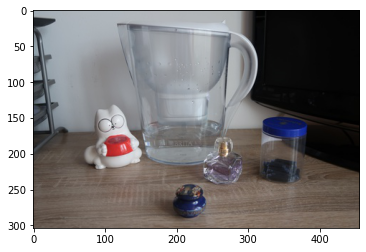

In [ ]:
for img in testimgloader:
    imdata = img
    break

plt.imshow(imdata['image'])
print(imdata['pose'])
print(imdata['hwf'])

In [ ]:
# for img in testimgloader:
#     eval_image_sample(models, img, loss_func, params_llff_eval, ndc=True, plot=True, batchify=True, b_size=12000)

In [ ]:
print(len(trainloader))
epochs = 20
metrics = { 'loss_train': [], 'iternum': []}
i_metrics = 500
# i_save_model = 11200
offset = 0

1517


# Functionalitati pentru antrenament

In [ ]:
# metrics_path = \
# '/gdrive/MyDrive/Nerf/Models/nerf_synthetic/metrics/metrics_' + blender_model +\
# '_' + 'full_56750.pt'

# checkpoint_path = \
# '/gdrive/MyDrive/Nerf/Models/nerf_synthetic/checkpoints/nerf_' +\
# blender_model + '_' + 'full' + '_'

# image_path = \
# '/gdrive/MyDrive/Nerf/Models/nerf_synthetic/outputs/' + blender_model +\
#  '_test_'

metrics_path = \
'/gdrive/MyDrive/Nerf/Models/nerf_llff/metrics/metrics_' + custom_model +\
'_8_128.pt'

checkpoint_path = \
'/gdrive/MyDrive/Nerf/Models/nerf_llff/checkpoints/nerf_' +\
custom_model + '_8_128_'

image_path = \
'/gdrive/MyDrive/Nerf/Models/nerf_llff/outputs/' + custom_model +\
 '_8_128_'

In [ ]:
print(metrics_path)
print(checkpoint_path)
print(image_path)

/gdrive/MyDrive/Nerf/Models/nerf_llff/metrics/metrics_birou_8_128.pt
/gdrive/MyDrive/Nerf/Models/nerf_llff/checkpoints/nerf_birou_8_128_
/gdrive/MyDrive/Nerf/Models/nerf_llff/outputs/birou_8_128_


In [ ]:
metrics = torch.load(metrics_path)
# 81600 pt llff
checkpoint = torch.load(checkpoint_path + '63710.tar')

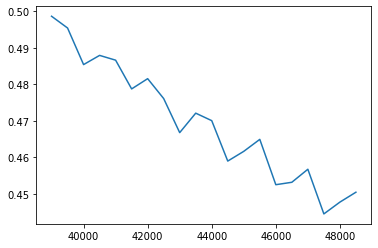

In [ ]:
plt.plot(metrics['iternum'][-20:], metrics['loss_train'][-20:])

In [ ]:
print(checkpoint.keys())

dict_keys(['model_coarse_state_dict', 'model_fine_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'iternum'])


In [ ]:
print(checkpoint['scheduler_state_dict'])

{'factor': 0.4, 'min_lrs': [0, 0], 'patience': 10, 'verbose': True, 'cooldown': 0, 'cooldown_counter': 0, 'mode': 'min', 'threshold': 0.0001, 'threshold_mode': 'rel', 'best': 0.4445505592157133, 'num_bad_epochs': 2, 'mode_worse': inf, 'eps': 1e-08, 'last_epoch': 97, '_last_lr': [0.0005, 0.0005]}


In [ ]:
models[0].load_state_dict(checkpoint['model_coarse_state_dict'])
models[1].load_state_dict(checkpoint['model_fine_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
offset = checkpoint['iternum']
print(offset)

48541


In [ ]:
print(np.array(metrics['iternum'])[np.argsort(metrics['loss_train'])][:10])
print(np.sort(metrics['loss_train'])[:10])

[47500 48000 48500 46000 46500 47000 44500 45000 45500 43000]
[0.44455056 0.44777883 0.45048726 0.452545   0.45320667 0.45677186
 0.45901032 0.46167386 0.46495171 0.46679499]


In [ ]:
print(scheduler.state_dict())

{'factor': 0.4, 'min_lrs': [0, 0], 'patience': 10, 'verbose': True, 'cooldown': 0, 'cooldown_counter': 0, 'mode': 'min', 'threshold': 0.0001, 'threshold_mode': 'rel', 'best': 0.4445505592157133, 'num_bad_epochs': 2, 'mode_worse': inf, 'eps': 1e-08, 'last_epoch': 97, '_last_lr': [0.0005, 0.0005]}


In [ ]:
# near, far, num_samples_coarse, num_samples_fine, emb_opts, \
    #   blend_alpha, stratify: bool, regularize:float, chunk

# params_blender_train = (2, 6, n1, n2, embed_options, True, True, 0., None)
# params_blender_eval = (2, 6, n1, n2, embed_options, True, True, 0., 1024*32*4)

params_llff_train = (0., 1., n1, n2, embed_options, False, True, 1., None)
params_llff_eval = (0., 1., n1, n2, embed_options, False, False, 0., None)

0.03693995534454007


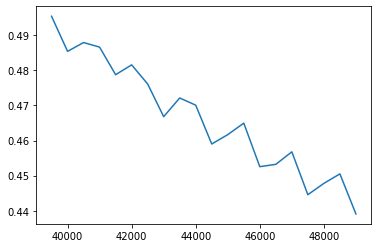

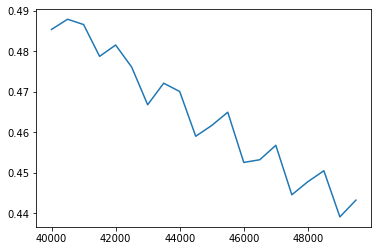

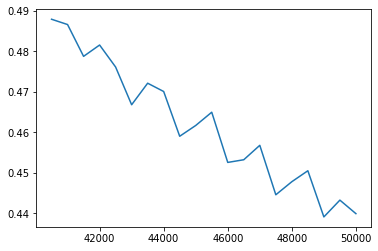

Salvare model...


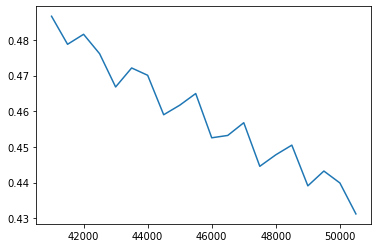

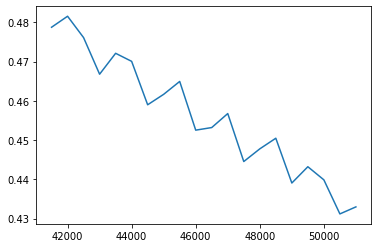

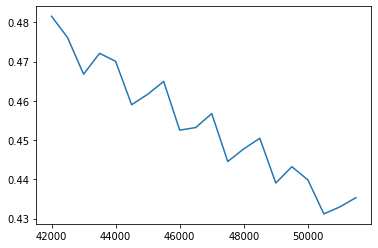

Salvare model...


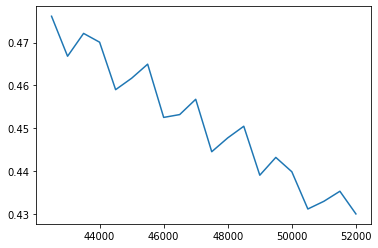

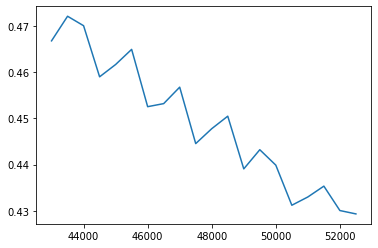

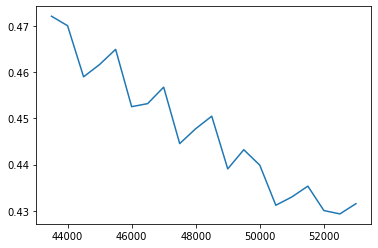

Salvare model...


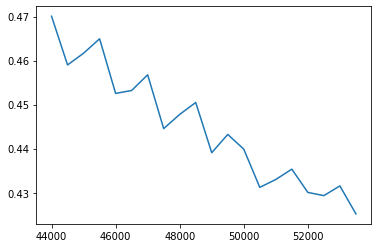

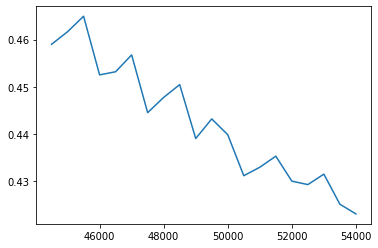

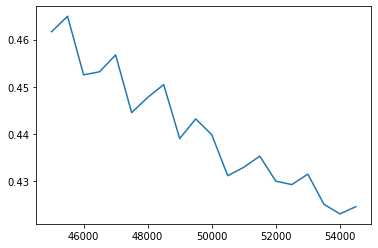

Salvare model...


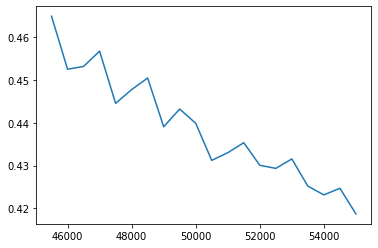

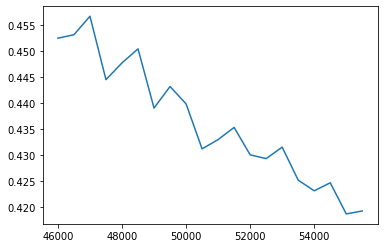

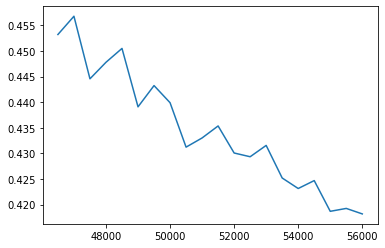

Salvare model...


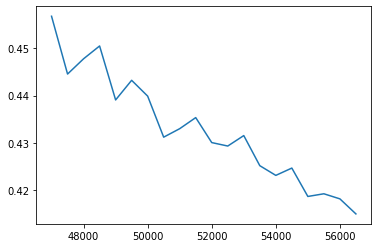

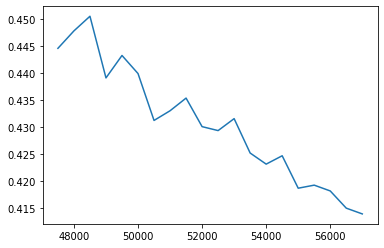

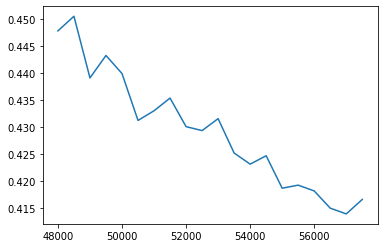

Salvare model...


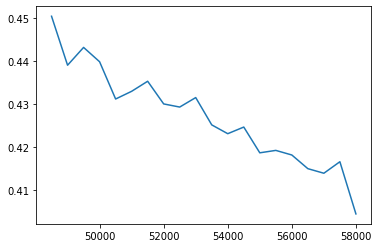

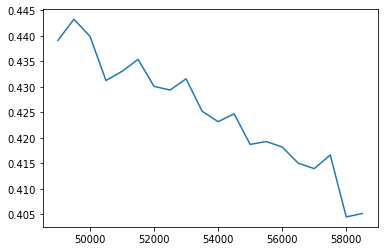

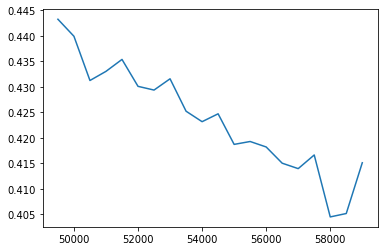

Salvare model...


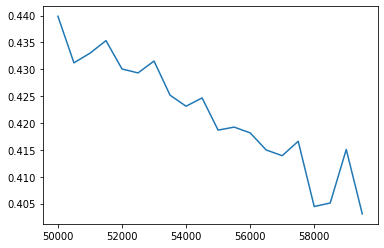

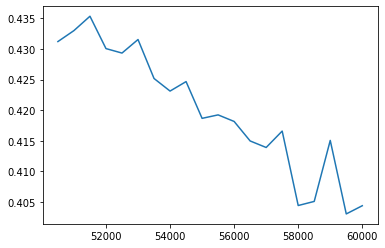

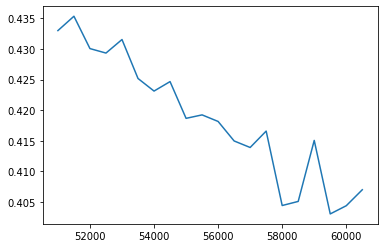

Salvare model...


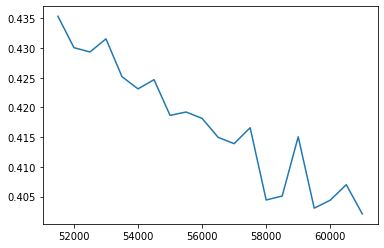

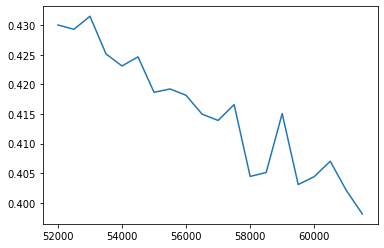

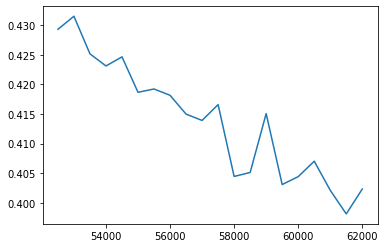

Salvare model...


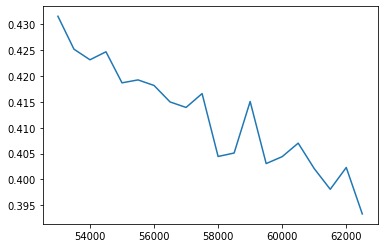

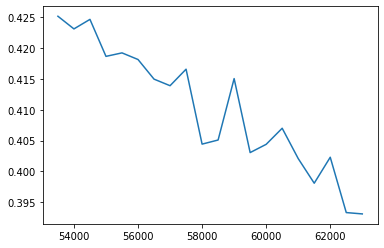

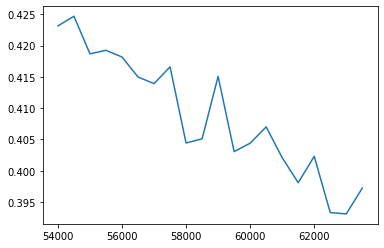

Salvare model...


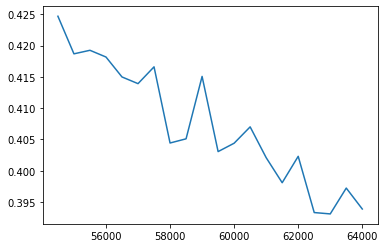

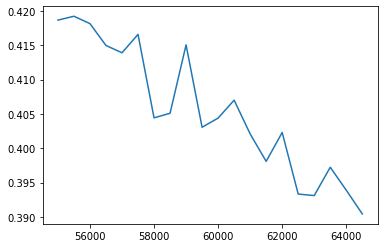

In [ ]:
miniepoch_loss = 0. # metrics['loss_train'][-1] *(offset - metrics['iternum'][-1]) / 500
for i in tqdm(range(epochs)):
    for j, data in enumerate(trainloader):
        batch_loss = train_batch(models, data, loss_func, optimizer, 
                                 params_llff_train)
        miniepoch_loss += batch_loss

        iteration = i * len(trainloader) + j
        first_flag = (iteration != 0)
        iteration += offset

        if first_flag and iteration % i_metrics == 0:
            scheduler.step(miniepoch_loss)
            
            metrics['iternum'].append(iteration)
            metrics['loss_train'].append(miniepoch_loss)
            miniepoch_loss = 0.
            plt.plot(metrics['iternum'][-20:], metrics['loss_train'][-20:])
            plt.show()
            
    # if first_flag and iteration % i_save_model == 0:
    print('Salvare model...')
    torch.save(metrics, metrics_path)
    torch.save({
        'model_coarse_state_dict': models[0].state_dict(),
        'model_fine_state_dict': models[1].state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'iternum': iteration
    }, checkpoint_path + str(iteration) + '.tar')

        # if j % i_plot==0:
            # iteration = i * len(trainloader) + j
            # psnr_c, psnr_f = eval_image_sample(model, imdata, loss_func, 
            #                 params_llff_eval, iter=iteration)
            
            # psnrs_c.append(psnr_c)
            # psnrs_f.append(psnr_f)
            # iternums.append(iteration)
            # torch.save(model.state_dict(), '/gdrive/MyDrive/Nerf/Models/nerf_synthetic/nerf_blender_ship_' + str(iteration) + '.pt')

In [ ]:
# miniepoch_loss = 0.
# for i in tqdm(range(epochs)):
#     for j, data in enumerate(trainloader):
#         batch_loss = train_batch(model, data, loss_func, optimizer, 
#                                  params_blender_train)
#         miniepoch_loss += batch_loss
        
#         iteration = i * len(trainloader) + j
#         first_flag = (iteration != 0)
#         iteration += offset

#         if first_flag and iteration % i_metrics == 0:
#             scheduler.step(miniepoch_loss)
            
#             metrics['iternum'].append(iteration)
#             metrics['loss_train'].append(miniepoch_loss)
#             miniepoch_loss = 0.
#             plt.plot(metrics['iternum'][-20:], metrics['loss_train'][-20:])
#             plt.show()
#             torch.save(metrics, metrics_path + str(iteration) + '.pt')
            
#         if first_flag and iteration % i_save_model == 0:
#             print('Salvare model...')
#             torch.save({
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'scheduler_state_dict': scheduler.state_dict(),
#                 'iternum': iteration
#             }, checkpoint_path + str(iteration) + '.tar')

#         # if j % i_plot==0:
#         #     iteration = i * len(trainloader) + j
            
#         #     psnr_c, psnr_f = eval_image_sample(model, imdata, loss_func, 
#         #                     params_blender_eval, iter=iteration)
            
#         #     psnrs_c.append(psnr_c)
#         #     psnrs_f.append(psnr_f)
#         #     iternums.append(iteration)
#             # torch.save(model.state_dict(), '/gdrive/MyDrive/Nerf/Models/nerf_synthetic/nerf_blender_' + blender_model + '_' + str(iteration) + '.pt')

# Metrici de testare


In [ ]:
results = {'psnrs': [], 'ssims': []}
# results = torch.load(metrics_path + 'results.pt')
print(results)

{'psnrs': [], 'ssims': []}


In [ ]:
# _, _, files = next(os.walk('/gdrive/MyDrive/Nerf/Models/nerf_synthetic/outputs/'))

# print(files)
# for i in range(200):
#     if os.path.exists(image_path + str(i) +'.png'):
#       print(i)

In [ ]:
# for key in results:
#   print(np.mean(results[key]))

In [ ]:
# for i, img in enumerate(testimgloader):
#     if os.path.exists(image_path + str(i) +'.png'):
#       print("Skipping image " + str(i))
#       continue
#     rgb, psnr, ssim = eval_image_sample(model, img, loss_func, params_blender_train, 
#                                         False, batchify=True, b_size=12*1024)

#     imageio.imwrite(image_path + str(i) + '.png', (rgb * 255).astype(np.uint8))
#     results['psnrs'].append(psnr.numpy())
#     results['ssims'].append(ssim.numpy())

#     print(results)
#     torch.save(results, metrics_path + 'results.pt')

In [ ]:
# scores = []

# for i, img in enumerate(trainset.images):
#     scores.append(tf.image.psnr(tf.convert_to_tensor(img.numpy()), tf.convert_to_tensor(frames_rgb[i] / 255, dtype=tf.float32), 1.))

# print([score.numpy() for score in scores][::])
# print(np.mean(scores[::]))

In [ ]:
# for i, img in enumerate(testimgloader):
#     # if os.path.exists(image_path + str(i) +'.png'):
#     #   print("Skipping image " + str(i))
#     #   continue
#     rgb_c, rgb_f, psnr, ssim = eval_image_sample(models, img, loss_func, params_llff_eval, 
#                                         ndc=True, plot=False, batchify=True, b_size=12*1024)

#     imageio.imwrite(image_path + str(i) + '_c.png', (rgb_c * 255).astype(np.uint8))
#     imageio.imwrite(image_path + str(i) + '_f.png', (rgb_f * 255).astype(np.uint8))

#     results['psnrs'].append(psnr.numpy())
#     results['ssims'].append(ssim.numpy())

#     print(results)
#     torch.save(results, metrics_path + 'results.pt')

In [ ]:
# print(np.mean(results['psnrs']))
# print(np.mean(results['ssims']))

20.06361
0.5347167


In [ ]:
# image0_ph = tf.placeholder(tf.float32)
# image1_ph = tf.placeholder(tf.float32)

# lpips_func = lpips_tf.lpips(image0_ph, image1_ph, model='net-lin', net='vgg')


>> Downloading net-lin_vgg_v0.1.pb 100.0%
Successfully downloaded net-lin_vgg_v0.1.pb 58955824 bytes.



In [ ]:
# gt_path = '/gdrive/MyDrive/Nerf/NeRF_Data/nerf_llff_data/' + llff_model + '/images_4'
#  _, _, a = next(os.walk(gt_path))
# a.sort()
# print(a)

In [ ]:
# def clipify(matrix):
#     return np.clip(matrix / 255, 0., 1.)

In [ ]:
# trues=[]
# for fname in a:
#   trues.append(clipify(imageio.imread(os.path.join(gt_path, fname))))

# trues = np.stack(trues, axis=0)
# print(trues.shape)

(20, 756, 1008, 3)


In [ ]:
# print(image_path)

/gdrive/MyDrive/Nerf/Models/nerf_synthetic/outputs/lego_test_


In [ ]:
# # coarses = []
# fines=[]
# for i in range(200):
#   # coarse_path = image_path + str(i) + '_c.png'
#   fine_path = image_path + str(i) + '.png'

#   # img_c = imageio.imread(coarse_path)
#   # coarses.append(clipify(img_c))

#   img_f = imageio.imread(fine_path)
#   fines.append(clipify(img_f))

In [ ]:
# imc = np.stack(coarses, axis=0)
# imf = np.stack(fines, axis=0)

In [ ]:
# print(testimages.images.shape, testimages.images.min(), testimages.images.max())

torch.Size([200, 800, 800, 3]) tensor(0.) tensor(1.)


In [ ]:
# print(imc.shape, imf.shape, imc.min(), imc.max(), imf.min(), imf.max())

() (200, 800, 800, 3) 1 1 0.0 1.0


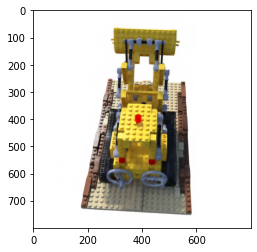

In [ ]:
# plt.imshow(imf[1])

In [ ]:
distance = np.zeros(imf.shape[0])
print(distance.shape)

(200,)


In [ ]:
with tf.Session() as session:
    for i in range(200):
      distance[i] = session.run(lpips_func, 
                feed_dict={image0_ph: testimages.images[i],
                           image1_ph: imf[i]})
print(distance)

0.22058731317520142


In [ ]:
dist_fine = np.array(distance)

In [ ]:
print(dist_coarse)

[0.59351659 0.54947388 0.52877247 0.5341773  0.50651932 0.52448344
 0.50822639 0.50724822 0.54870623 0.55470783 0.54908514 0.50459564
 0.50718182 0.51866311 0.53150791 0.52912283 0.57791609 0.52089006
 0.53965372 0.55030876]


In [ ]:
print(dist_fine)

[0.1237777  0.12611639 0.12839833 0.12729406 0.12513079 0.12520657
 0.12309767 0.12768579 0.12600838 0.13129923 0.12849228 0.12758248
 0.12631708 0.12433428 0.12414624 0.12061072 0.12104834 0.11990391
 0.12340502 0.12338653 0.12497629 0.12376773 0.12288133 0.12361112
 0.12190481 0.12279518 0.1227224  0.12459235 0.12400328 0.12339617
 0.1228243  0.12298407 0.12424965 0.1226875  0.1234917  0.12344687
 0.12267408 0.12109348 0.12058848 0.12151618 0.12287431 0.12165759
 0.12045369 0.11917932 0.11932601 0.11817333 0.11471893 0.11455028
 0.11221416 0.1100135  0.10760923 0.10881686 0.11206174 0.11049016
 0.11252213 0.11557684 0.11347587 0.11475855 0.11466806 0.12017567
 0.12063058 0.11753393 0.11451376 0.11325729 0.11495361 0.11537604
 0.1175262  0.11939421 0.11989155 0.11992104 0.1175274  0.11937555
 0.1182759  0.1229957  0.123933   0.1291548  0.12959151 0.13217974
 0.13250455 0.13535812 0.13826421 0.14025694 0.13818046 0.13978906
 0.14062276 0.1419785  0.13978879 0.13922845 0.13708062 0.1362

# Generarea rezultatelor

Imaginea coarse: tensorflow vs skimage
tf.Tensor(26.70192, shape=(), dtype=float32) tf.Tensor(0.8844333, shape=(), dtype=float32)
26.701921487649116 0.9214541685123184
Imaginea fine: tensorflow vs skimage
tf.Tensor(29.460718, shape=(), dtype=float32) tf.Tensor(0.92212826, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29.46072010515376 0.949807432168232
tensor(0.0001) tensor(1.0000)


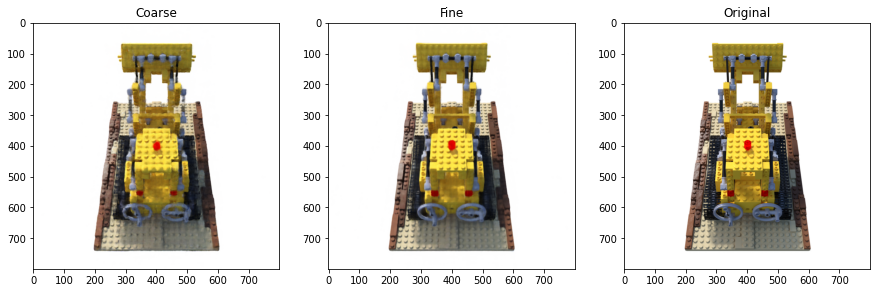

(tensor(26.7019), tensor(29.4607))

In [ ]:
# eval_image_sample(model, imdata, loss_func, params_blender_train, True, batchify=True)

In [ ]:
# translate_z = lambda z: np.array([
#     [1, 0, 0, 0],
#     [0, 1, 0, 0],
#     [0, 0, 1, z],
#     [0, 0, 0, 1]
# ], dtype=np.float32)

# rotate_x = lambda ang: np.array([
#     [1,           0,            0, 0],
#     [0, np.cos(ang), -np.sin(ang), 0],
#     [0, np.sin(ang),  np.cos(ang), 0],
#     [0,           0,            0, 1]
# ], dtype=np.float32)

# rotate_y = lambda ang: np.array([
#     [np.cos(ang), 0, -np.sin(ang), 0],
#     [          0, 1,            0, 0],
#     [np.sin(ang), 0,  np.cos(ang), 0],
#     [0,           0,            0, 1]
# ], dtype=np.float32)

In [ ]:
# def generate_pose_polar_coords(phi, theta, radius):
#     cam_to_world = translate_z(radius)
#     cam_to_world = rotate_y(theta) @ rotate_x(phi)  @ cam_to_world
    
#     # Inversam coordonatele pe x, interschimbam axele y si z
#     cam_to_world = \
#         np.array([[-1, 0, 0, 0], 
#                   [ 0, 0, 1, 0], 
#                   [ 0, 1, 0, 0], 
#                   [ 0, 0, 0, 1]], dtype=np.float32) @ cam_to_world

#     return cam_to_world

In [ ]:
# frames = []

# with torch.no_grad():
#     for y_ang in tqdm(np.linspace(2/3 * np.pi, 2 * np.pi, 1, endpoint=False)):
#         for model in models:
#           model.eval()
#         pose = generate_pose_polar_coords(np.radians(-30.), y_ang, 4.)

#         rays = extract_rays(800, 800, 1111.1110311937682, torch.from_numpy(pose))
#         rgb_c, rgb_f, depth, acc = render_rays(models, rays.to(device), params_blender_eval)

#         rgb = rgb_f.cpu().reshape(800, 800, 3)
#         frames.append((255 * np.clip(rgb.numpy(), 0, 1)).astype(np.uint8))

#         depth = depth.cpu().reshape(800, 800)
#         frames.append(depth)

In [ ]:
def create_llff_video_poses(dataset, n_img=120, n_rot=2):
    # avg_pose = dataset.avg_pose

    # (3), rotatia pe y
    # up = normalize(np.sum(dataset.all_poses[..., 1].numpy(), axis=0))
    up = np.array([0., 1., 0.])

    f_depth = 3.5
    rads = np.percentile(np.abs(dataset.all_poses[..., 3]), 90, axis=0)

    video_poses = []
    # rads = np.array(list(rads) + [1.])

    for angle in np.linspace(0, 2 * n_rot * np.pi, n_img, endpoint=False):
        # position = np.dot(avg_pose, np.array([np.cos(angle), 
        #                                      -np.sin(angle), 
        #                                      -np.sin(angle / 2),
        #                                       1]) * rads)
        position = np.array([np.cos(angle), 
                            -np.sin(angle), 
                            -np.sin(angle / 2)]) * rads

        # z = normalize(position - np.dot(avg_pose, np.array([0, 0, -f_depth, 1])))
        z = normalize(position - np.array([0, 0, -f_depth]))


        x = normalize(np.cross(up, z))
        y = normalize(np.cross(z, x))

        video_poses.append(np.column_stack((x, y, z, position)))
    
    return torch.tensor(video_poses, dtype=torch.float32)

In [ ]:
params_llff_eval = (0., 1., n1, n2, embed_options, False, True, 0., None)

In [ ]:
poses = create_llff_video_poses(trainset)
print(poses.shape)

In [ ]:
frames_rgb = []
frames_d = []

with torch.no_grad():
    for model in models:
        model.eval()
    skipped = 0
    for j, pose in tqdm(enumerate(poses)):
        if (os.path.exists(image_path + 'rgb_' + str(j) + '.png')):
            print("Skipping " + str(j))
            skipped += 1
            continue

        # pose = trainset.poses[0]
        H, W, focal = trainset.hwf

        rays = convert_to_ndc(H, W, focal, 1., extract_rays(H, W, focal, pose)).to(device)

        # co=[]
        fi=[]
        de=[]
        batch_eval = 12500
        for i in range(0, H * W, batch_eval):
            rgb_c, rgb_f, depth, acc = render_rays(models, 
                                                rays[i:i+batch_eval], 
                                                params_llff_eval)
            # co.append(rgb_c)
            fi.append(rgb_f)
            de.append(depth)

        # rgb_c = torch.cat(co)
        rgb_f = torch.cat(fi)
        depth = torch.cat(de)

        # rgb_c, rgb_f, depth, acc = render_rays(models, rays, params_llff_eval)

        rgb = rgb_f.cpu().reshape(H, W, 3)
        frames_rgb.append((255 * np.clip(rgb.numpy(), 0, 1)).astype(np.uint8))

        bw = depth.cpu().reshape(H, W)
        frames_d.append((255 * (1. - np.clip(bw.numpy(), 0, 1))).astype(np.uint8))

        imageio.imwrite(image_path + 'rgb_' + str(j) + '.png', frames_rgb[j - skipped])
        imageio.imwrite(image_path + 'depth_' + str(j) + '.png', frames_d[j - skipped])

In [ ]:
# for i, img in enumerate(testimgloader):
#     # if os.path.exists(image_path + str(i) +'.png'):
#     #   print("Skipping image " + str(i))
#     #   continue
#     rgb_c, rgb_f, psnr, ssim = eval_image_sample(models, img, loss_func, params_llff_eval, 
#                                         ndc=True, plot=False, batchify=True, b_size=12*1024)

#     imageio.imwrite(image_path + str(i) + '_c.png', (rgb_c * 255).astype(np.uint8))
#     imageio.imwrite(image_path + str(i) + '_f.png', (rgb_f * 255).astype(np.uint8))

#     results['psnrs'].append(psnr.numpy())
#     results['ssims'].append(ssim.numpy())

#     print(results)
#     torch.save(results, metrics_path + 'results.pt')

In [ ]:
frames = []

with torch.no_grad():
    for model in models:
        model.eval()
    pose = testimages.poses[3]
    H, W, focal = testimages.hwf

    rays = convert_to_ndc(H, W, focal, 1., extract_rays(H, W, focal, pose)).to(device)

    co=[]
    fi=[]
    batch_eval = 10000
    for i in range(0, H * W, batch_eval):
        rgb_c, rgb_f, depth, acc = render_rays(models, 
                                               rays[i:i+batch_eval], 
                                               params_llff_eval)
        co.append(rgb_c)
        fi.append(rgb_f)

In [ ]:
rgb_c = torch.cat(co)
rgb_f = torch.cat(fi)

rgb = rgb_c.cpu().reshape(H, W, 3)
frames.append((255 * np.clip(rgb.numpy(), 0, 1)).astype(np.uint8))

rgb = rgb_f.cpu().reshape(H, W, 3)
frames.append((255 * np.clip(rgb.numpy(), 0, 1)).astype(np.uint8))

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

In [ ]:
imageio.imwrite('lego_good.png', frames[1])

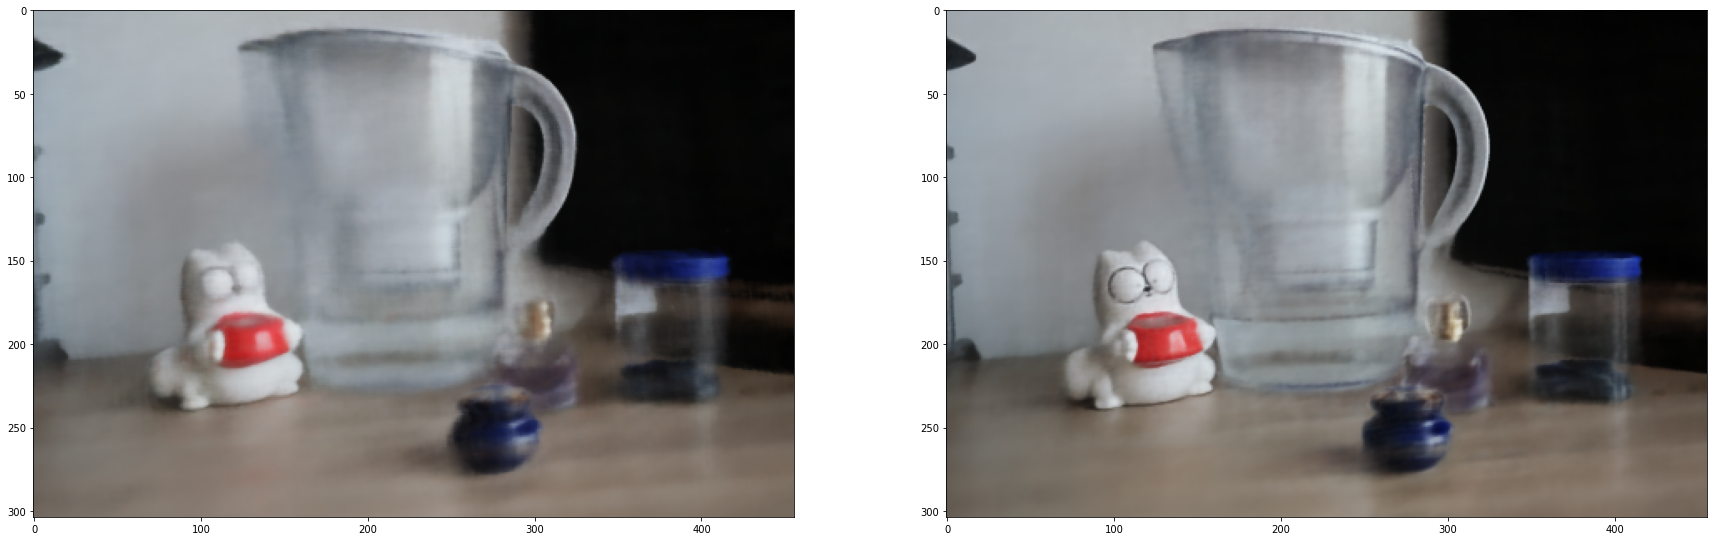

In [ ]:
ax = plt.figure(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.imshow(frames[0])

plt.subplot(1, 2, 2)
plt.imshow(frames[1])

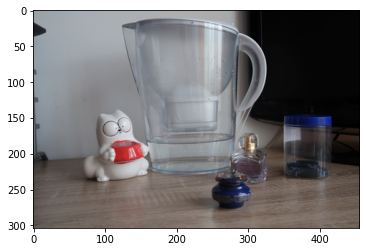

In [ ]:
original = testimages.images[3]#[19 * 1008 * 756:20 * 1008 * 756].reshape(H, W, 3)
plt.imshow(original)

In [ ]:
imageio.imwrite('ferndepth.png', frames[1])

In [ ]:
print(peak_signal_noise_ratio(original.cpu().numpy(), frames[1] / 255))

29.748440305663237


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  """Entry point for launching an IPython kernel.


In [ ]:
f = 'ship.mp4'
imageio.mimwrite(f, frames, fps=30, quality=9)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('ship.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)